# Universidad de Buenos Aires
# Deep Learning - TP
# Cohorte 17 - 5to bimestre 2024


# Fuente del dataset
El dataset utilizado en este análisis fue obtenido de una empresa minorista «ABC Private Limited» compartió resúmenes de compra de varios clientes para productos seleccionados de gran volumen del mes pasado. Puedes acceder al dataset completo en el siguiente enlace:

[Dataset en Google Drive](https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view)

### **Sobre los datos**
En este [link](https://www.kaggle.com/datasets/prepinstaprime/black-friday-sales-data/data) se encuentra información detalla sobre las variables que componen al dataset.

* Información sobre el cliente
  *  User_ID: identificación del usuario.
  *  Gender: sexo del usuario.
  *  Age: edad en intervalos.
  *  Ocuppation: ocupación (enmascarada).
  *  Marital_Status: estado civil.
  *  City_Category: categoría de la ciudad (A,B,C).
  *  Stay_In_Current_City_Years: número de años que lleva en la ciudad actual.

* Información sobre el producto
  * Product_ID: identificación del producto.
  * Product_Category_1:	categoría 1 del producto.
  * Product_Category_2:	categoría 2 del producto.
  * Product_Category_3: categoría 3 del producto.
  * **Purchase**: importe total de la compra del mes pasado.

La variable `purchase` es la variable que se quiere predecir (target). Se trata de un problema de _clasficación multiclase_.




## Parte 1



### a) Praparacion del dataset

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import (
    MaxAbsScaler,
    LabelEncoder,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [ ]:
RANDOM_STATE = 42

In [ ]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/qagustina/ceia-uba/refs/heads/main/AP/dataset_black_sales.csv')

In [ ]:
num_obs = df.shape[0]
num_variables = df.shape[1]

data_types = df.dtypes.value_counts()

description = f"""
El dataset cargado tiene las siguientes características principales

- **Número de observaciones:** {num_obs}
- **Número de variables:** {num_variables}

Tipos de datos:
"""
for v_types, v_count in data_types.items():
    description += f"- Existen ({v_count} variables) de tipo **{v_types}** .\n"

display(Markdown(description))


El dataset cargado tiene las siguientes características principales

- **Número de observaciones:** 550068
- **Número de variables:** 12

Tipos de datos:
- Existen (5 variables) de tipo **int64** .
- Existen (5 variables) de tipo **object** .
- Existen (2 variables) de tipo **float64** .


Observamos las primeras y últimas 5 filas

In [ ]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [ ]:
df.tail()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
550063,1006033,P00372445,M,51-55,13,B,1,1,20,NaN,NaN,368
550064,1006035,P00375436,F,26-35,1,C,3,0,20,NaN,NaN,371
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,NaN,NaN,137
550066,1006038,P00375436,F,55+,1,C,2,0,20,NaN,NaN,365
550067,1006039,P00371644,F,46-50,0,B,4+,1,20,NaN,NaN,490


- Valores Nulos

In [ ]:
df.isnull().sum().to_frame('count')

,count
User_ID,0
Product_ID,0
Gender,0
Age,0
Occupation,0
City_Category,0
Stay_In_Current_City_Years,0
Marital_Status,0
Product_Category_1,0
Product_Category_2,173638


<Axes: >

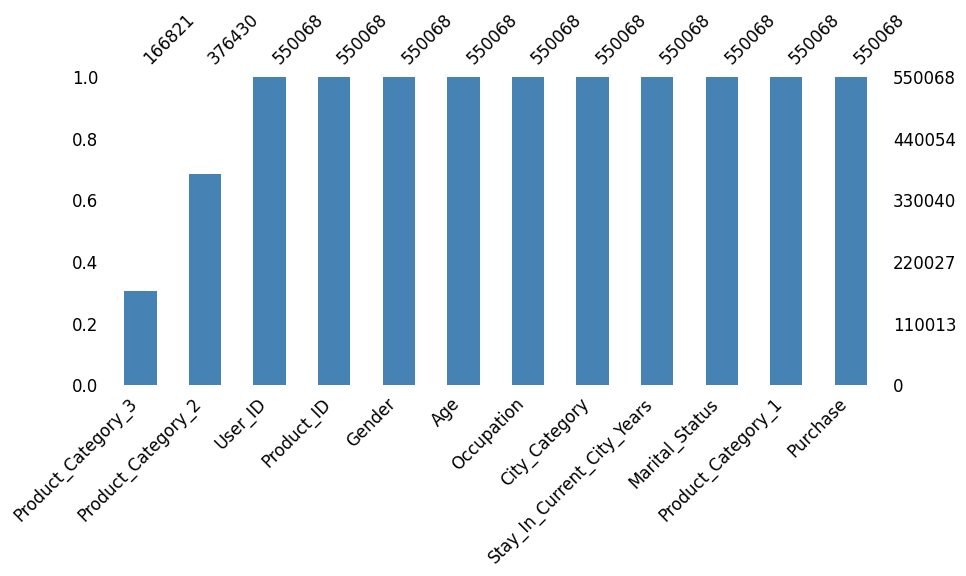

In [ ]:
msno.bar(df,figsize=(10, 4), sort="ascending",fontsize=12, color='steelblue')

In [ ]:
nan_counts = round(df.isnull().sum() / len(df), 2)
nan_counts

,0
User_ID,0.00
Product_ID,0.00
Gender,0.00
Age,0.00
Occupation,0.00
City_Category,0.00
Stay_In_Current_City_Years,0.00
Marital_Status,0.00
Product_Category_1,0.00
Product_Category_2,0.32


Las variables `Product_Category_2` y `Product_Category_3` tienen valores nulos, representando un **32%** y **70%** respectivamente sobre el total de los datos.

Observamos si los datos faltantes tienen alguna relación entre ellos

<Axes: >

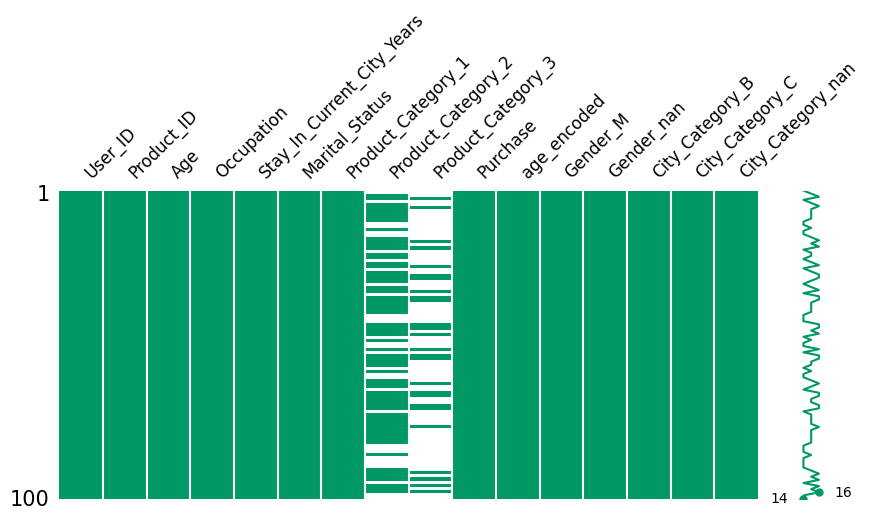

In [ ]:
msno.matrix(df.sample(100),figsize=(10, 4), fontsize=12, color=[0,0.6,0.4])

En la matriz se observa que, no existe una relación de las columnas con valores faltantes con el resto de ellas.

- Duplicados

In [ ]:
df.duplicated().sum()

0

El dataset no presenta valores duplicados.

#### **Visualizaciones**



In [ ]:
numerical_variables = ['Occupation', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']

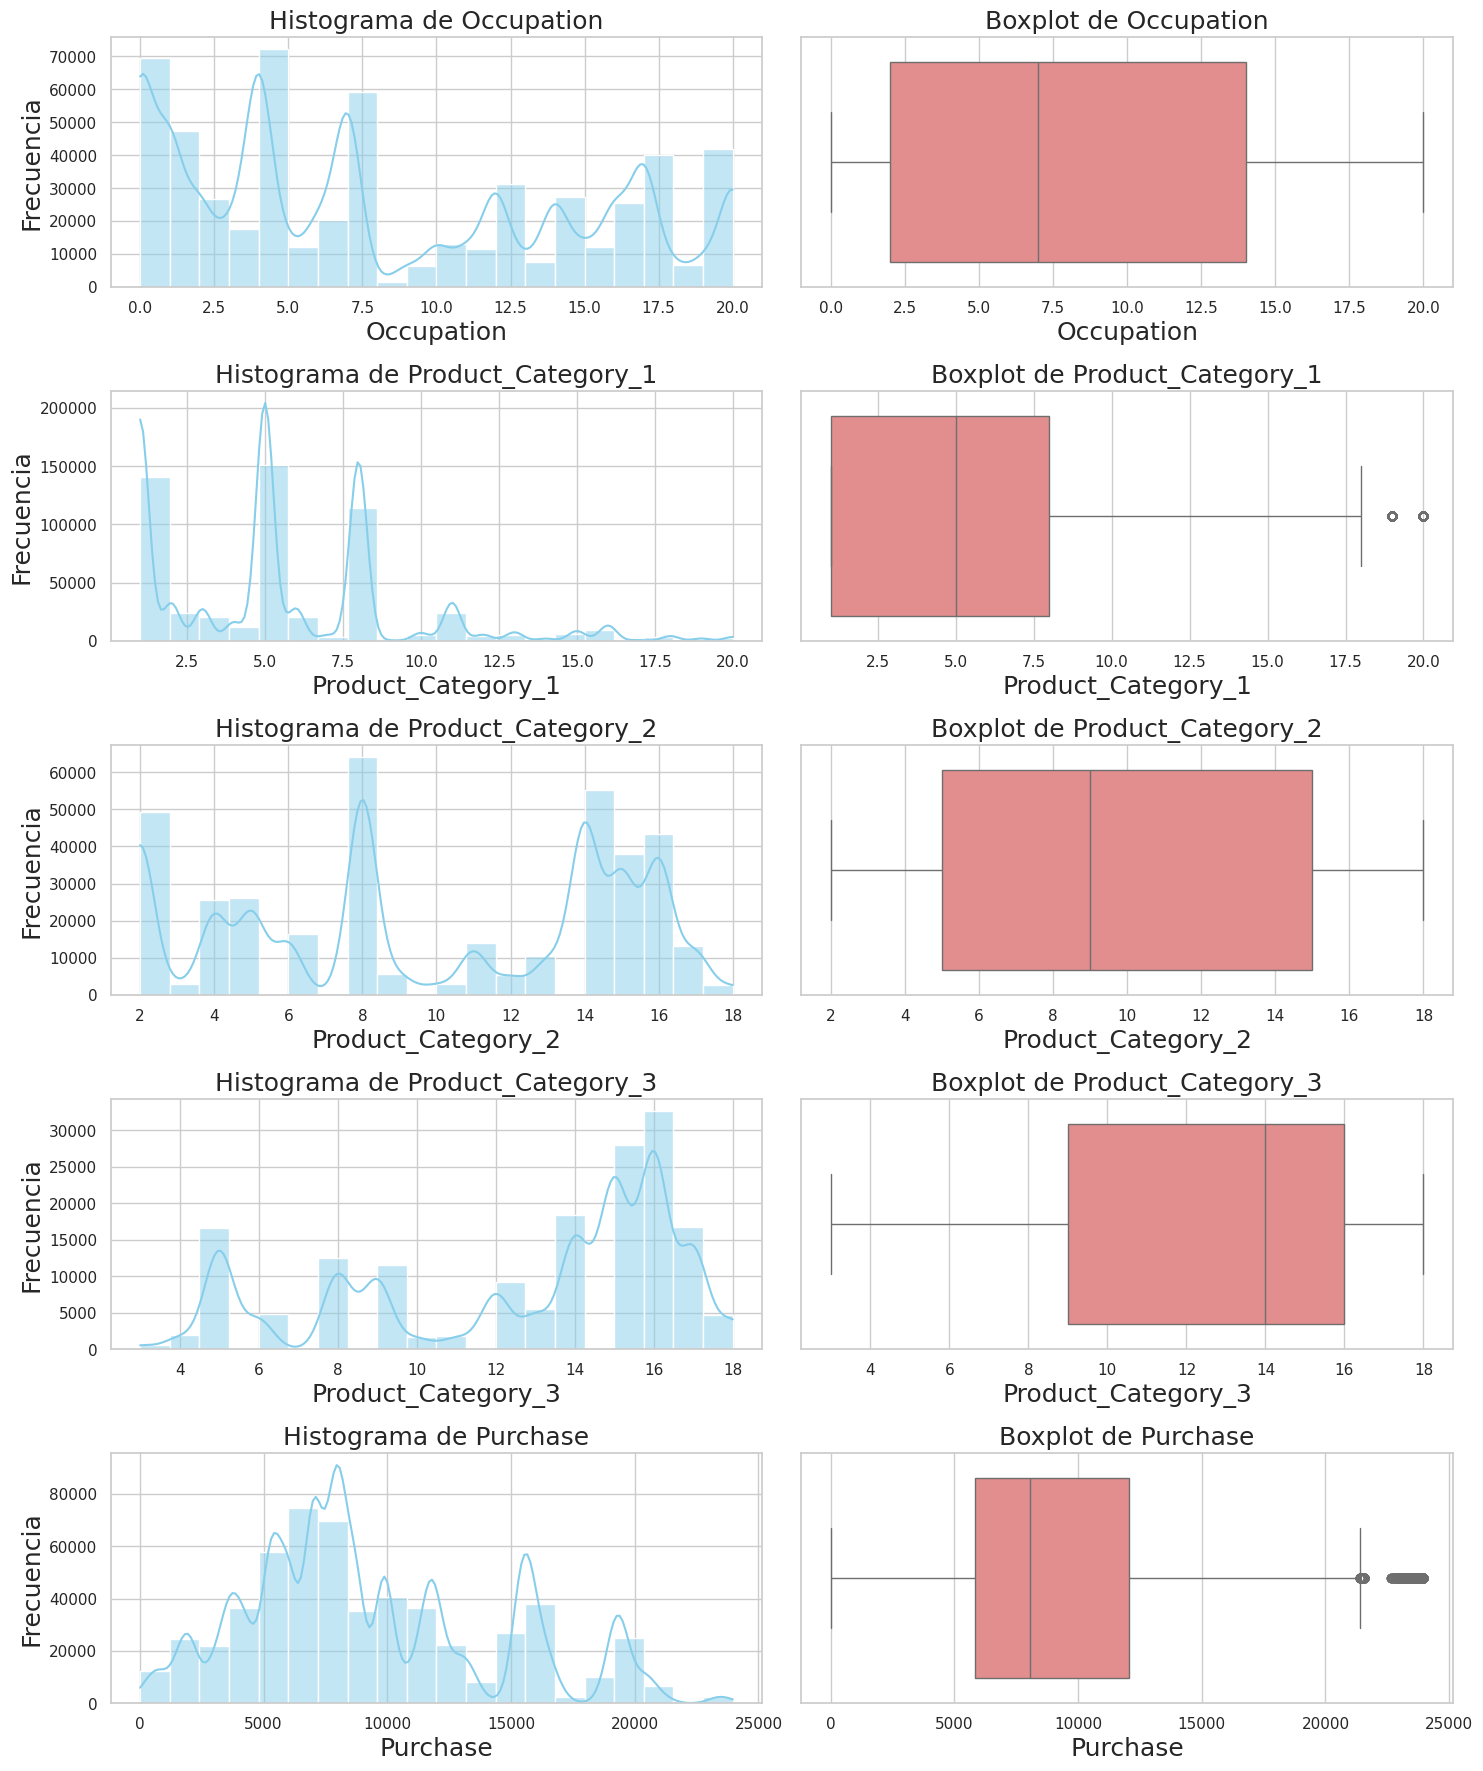

In [ ]:
plt.figure(figsize=(15, 35))

for i, variable in enumerate(numerical_variables, 1):
    plt.subplot(10, 2, i*2-1)
    sns.histplot(df[variable], bins=20, kde=True, color='skyblue')
    plt.title(f'Histograma de {variable}', fontsize=18)
    plt.xlabel(variable, fontsize=18)
    plt.ylabel('Frecuencia', fontsize=18)

    plt.subplot(10, 2, i*2)
    sns.boxplot(x=df[variable], color='lightcoral')
    plt.title(f'Boxplot de {variable}', fontsize=18)
    plt.xlabel(variable, fontsize=18)

plt.subplots_adjust(hspace=0.6)

plt.tight_layout()
plt.show()

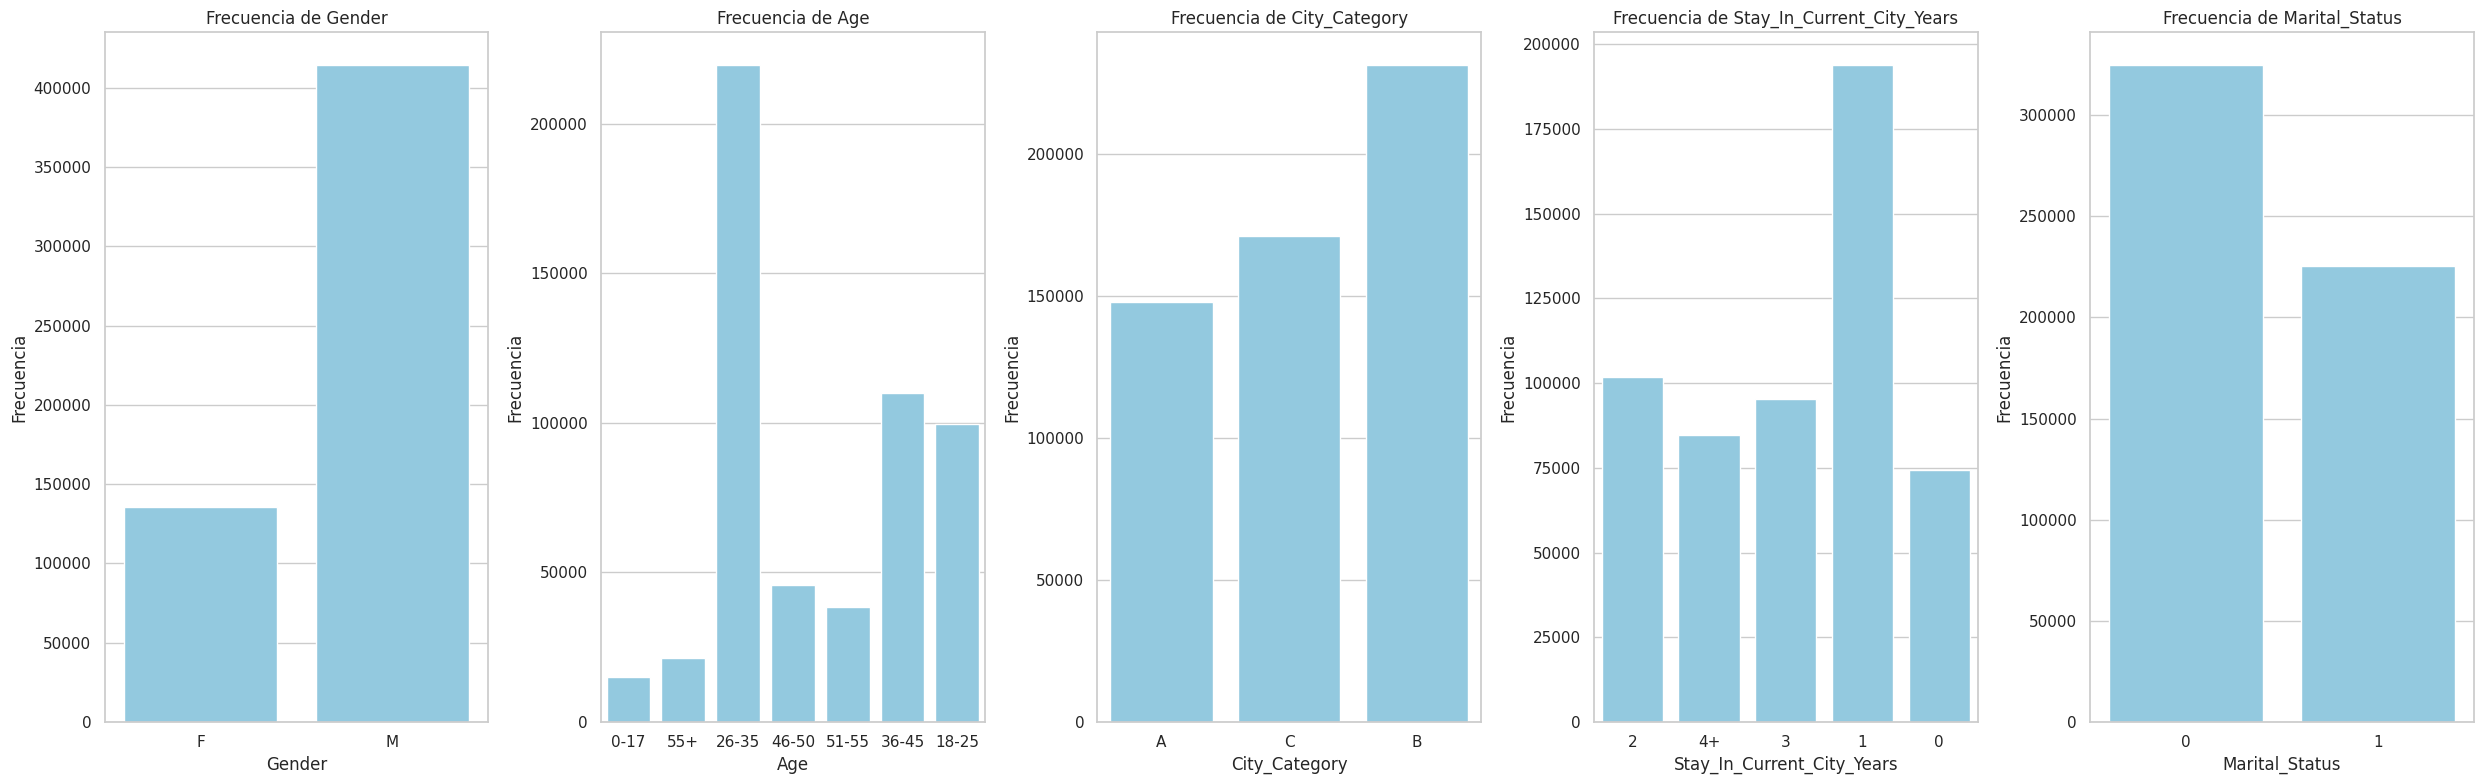

In [ ]:
variables_categoricas = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']

plt.figure(figsize=(25, 8))

for i, variable in enumerate(variables_categoricas, 1):
    plt.subplot(1, 5, i)
    sns.countplot(x=variable, data=df, color='skyblue')
    plt.title(f'Frecuencia de {variable}', fontsize=12)
    plt.xlabel(variable, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.show()

#### **Tratamiento de variables**

In [ ]:
sales_df = df.copy()

In [ ]:
le = LabelEncoder()
sales_df['age_encoded'] = le.fit_transform(sales_df['Age'].astype(str))

In [ ]:
sales_df[['Age', 'age_encoded']]

,Age,age_encoded
0,0-17,0
1,0-17,0
2,0-17,0
3,0-17,0
4,55+,6
...,...,...
550063,51-55,5
550064,26-35,2
550065,26-35,2
550066,55+,6


*  Creación de variables dummies para las columnas `Gender` y `City_Category`

In [ ]:
sales_df = pd.get_dummies(sales_df, columns=['Gender', 'City_Category'], dummy_na=True, drop_first=True)
display(sales_df.head(2))
print(sales_df.shape)

,User_ID,Product_ID,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,age_encoded,Gender_M,Gender_nan,City_Category_B,City_Category_C,City_Category_nan
0,1000001,P00069042,0-17,10,2,0,3,NaN,NaN,8370,0,False,False,False,False,False
1,1000001,P00248942,0-17,10,2,0,1,6.0,14.0,15200,0,False,False,False,False,False


(550068, 16)


In [ ]:
sales_df['Stay_In_Current_City_Years'] = sales_df['Stay_In_Current_City_Years'].str.replace('+', '', regex=False)
sales_df = sales_df.astype({"Stay_In_Current_City_Years": 'int'})


**Imputación de variables**

Dado que, las columnas `Product_Category_2` y `Product_Category_3` no tienen una distribución normal, se realiza un proceso de imputación de variables respecto a la **mediana**.

In [ ]:
columns_to_impute = ['Product_Category_2', 'Product_Category_3']

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

sales_df[columns_to_impute] = imp_mean.fit_transform(sales_df[columns_to_impute])

print(sales_df[columns_to_impute].head())


   Product_Category_2  Product_Category_3
0                 9.0                14.0
1                 6.0                14.0
2                 9.0                14.0
3                14.0                14.0
4                 9.0                14.0


In [ ]:
sales_df = sales_df.astype({"Product_Category_2": 'int', "Product_Category_3":'int'})

* Definición de grupos para la columna *Purchase*
  * grupo 0 (gasta menos de 5000)
  * grupo 1 (gasta entre 5000 y 10000)
  * grupo 2 (gasta entre 10000 y 15000)
  * grupo 3 (gasta más de 15000)

In [ ]:
def categorize_purchase(purchase):
    if purchase < 5000:
        return 0
    elif 5000 <= purchase < 10000:
        return 1
    elif 10000 <= purchase < 15000:
        return 2
    else:
        return 3

sales_df['target'] = sales_df['Purchase'].apply(categorize_purchase).astype(int)

display(sales_df[['Purchase', 'target']].head())


,Purchase,target
0,8370,1
1,15200,3
2,1422,0
3,1057,0
4,7969,1


In [ ]:
sales_df['Product_ID'] = sales_df['Product_ID'].str.replace('^P', '1', regex=True).astype(int)
display(sales_df['Product_ID'].head())


,Product_ID
0,100069042
1,100248942
2,100087842
3,100085442
4,100285442


Luego del proceso de transformación, se crea un nuevo dataframe con las columnas relevantes.

In [ ]:
cols_to_keep = ['User_ID', 'Product_ID', 'Occupation', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2',
                'Product_Category_3', 'age_encoded', 'Gender_M', 'City_Category_B', 'City_Category_C', 'target']

In [ ]:
ml_df = sales_df[cols_to_keep]
ml_df.columns = ml_df.columns.str.lower()

In [ ]:
ml_df.sample(5)

,user_id,product_id,occupation,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,age_encoded,gender_m,city_category_b,city_category_c,target
294612,1003456,100125942,17,3,0,1,2,15,2,True,False,True,3
313053,1000235,100116942,0,0,0,6,10,16,2,True,True,False,3
395486,1000897,100277442,6,4,0,1,6,15,2,True,True,False,3
341676,1004543,100325942,2,0,0,5,9,14,2,True,False,False,1
120173,1000550,100104842,8,1,1,8,9,14,4,True,True,False,1


Correlación entre todas las variables

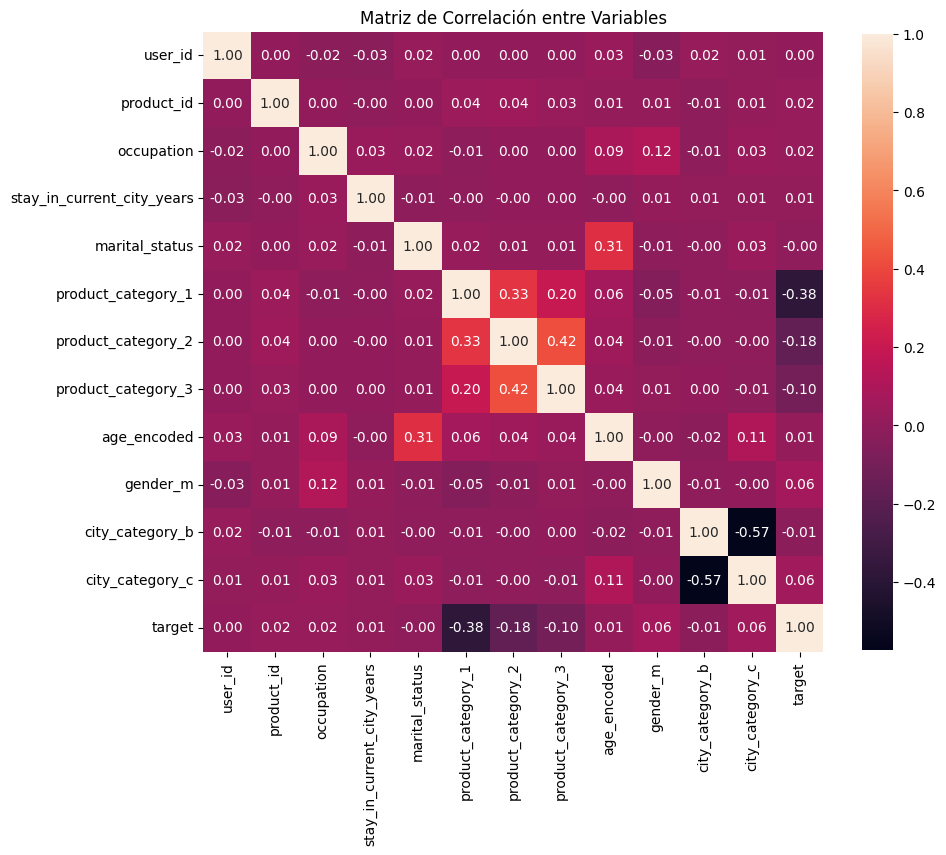

In [ ]:
correlation_matrix = ml_df.corr()

fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, cbar_kws={"shrink": 0.80}
                 )

plt.title('Matriz de Correlación entre Variables')
plt.show()

Tomando un umbral de 0.9 para considerar _alta correlación_, en el gráfico de heatmap no se observan correlaciones de este tipo tanto para valores positivos como negativos, por lo que se considera que todas las variables aportan información relevante para los modelos de machine learning y deep learning.

### b) Benchmark para comparar los modelos.

- Desbalance de Clases

In [ ]:
ml_df['target'].value_counts()

,count
target,
1,265606
3,110523
0,94923
2,79016


In [ ]:
# split
y = ml_df.target
X = ml_df.drop('target',axis = 1)

In [ ]:
y.head()

,target
0,1
1,3
2,0
3,0
4,1


In [ ]:
X.head()

,user_id,product_id,occupation,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,age_encoded,gender_m,city_category_b,city_category_c
0,1000001,100069042,10,2,0,3,9,14,0,False,False,False
1,1000001,100248942,10,2,0,1,6,14,0,False,False,False
2,1000001,100087842,10,2,0,12,9,14,0,False,False,False
3,1000001,100085442,10,2,0,12,14,14,0,False,False,False
4,1000002,100285442,16,4,0,8,9,14,6,True,False,True


In [ ]:
X.describe()

,user_id,product_id,occupation,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,age_encoded
count,5.500680e+05,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,9.862039e+07,8.076707,1.858418,0.409653,5.404270,9.576434,13.596114,2.496430
std,1.727592e+03,1.173602e+07,6.522660,1.289443,0.491770,3.936211,4.226025,2.352863,1.353632
min,1.000001e+06,1.000984e+07,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
25%,1.001516e+06,1.000887e+08,2.000000,1.000000,0.000000,1.000000,8.000000,14.000000,2.000000
50%,1.003077e+06,1.001697e+08,7.000000,2.000000,0.000000,5.000000,9.000000,14.000000,2.000000
75%,1.004478e+06,1.002591e+08,14.000000,3.000000,1.000000,8.000000,14.000000,14.000000,3.000000
max,1.006040e+06,1.003754e+08,20.000000,4.000000,1.000000,20.000000,18.000000,18.000000,6.000000


In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_normalized = normalizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=45, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)
# De esta forma, train, val, test set será el 60%, 20%, 20% del dataset respectivamente.

Se agrega el parámetro `labels=np.unique(y_train_predict)` para ayudar a los modelos a que tengan en cuenta a todas las clases presentes en las predicciones.

In [ ]:
def metricas(a, b):
  print(f"Accuracy: %.4f" % (accuracy_score(a, b)), '\n'
        f"Presicion: %.4f" % (precision_score(a, b,  average='weighted', labels=np.unique(y_train_predict))), '\n'
        f"Recall: %.4f" % (recall_score(a, b,  average='weighted', labels=np.unique(y_train_predict))), '\n'
        f"F1: %.4f" % (f1_score(a, b,  average='weighted', labels=np.unique(y_train_predict))), '\n')

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
lr_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

- Train

In [ ]:
y_train_predict = lr_clf.predict(X_train)

In [ ]:
metricas(y_train, y_train_predict)

Accuracy: 0.4815 
Presicion: 0.4313 
Recall: 0.7346 
F1: 0.4927 



- Val

In [ ]:
y_val_pred =  lr_clf.predict(X_val)
metricas(y_val, y_val_pred)

Accuracy: 0.4813 
Presicion: 0.4308 
Recall: 0.7344 
F1: 0.4923 



### c) Modelo sin embeddings.

Se excluyen las variables `user_id`, `product_id`

In [ ]:
X_new = X[['occupation', 'stay_in_current_city_years', 'marital_status',	'product_category_1', 'product_category_2',
      'product_category_3', 'age_encoded', 'gender_m', 'city_category_b', 'city_category_c']]

In [ ]:
X_new.head()

,occupation,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,age_encoded,gender_m,city_category_b,city_category_c
0,10,2,0,3,9,14,0,False,False,False
1,10,2,0,1,6,14,0,False,False,False
2,10,2,0,12,9,14,0,False,False,False
3,10,2,0,12,14,14,0,False,False,False
4,16,4,0,8,9,14,6,True,False,True


In [ ]:
X_new.shape

(550068, 10)

In [ ]:
X_new = X_new.astype({'gender_m': int, 'city_category_b': int, 'city_category_c': int})

X_tensor = torch.tensor(X_new.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

In [ ]:
# train 80% - validation 20%
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

n_train = X_train.shape[0]
n_valid = X_val.shape[0]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: torch.Size([440054, 10]), y_train shape: torch.Size([440054])
X_val shape: torch.Size([110014, 10]), y_val shape: torch.Size([110014])


In [ ]:
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
train_ds = MyDataset(X_train, y_train)
valid_ds = MyDataset(X_val, y_val)

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

In [ ]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=10, out_features=200, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=50, out_features=4, bias=True)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.linear_3(x)
        x = self.relu_3(x)
        x = self.output(x)
        return x


In [ ]:
nnet = NNet()

In [ ]:
class_counts = y.value_counts().to_list()
total_samples = sum(class_counts)

weights = [total_samples / count for count in class_counts]
weights = torch.tensor(weights, dtype=torch.float32)

In [ ]:
# torch.nn.BCEWithLogitsLoss(reduction='sum')
# torch.optim.Adam(nnet.parameters(), lr=0.01, weight_decay=0.01)
loss_function =  torch.nn.CrossEntropyLoss(weight=weights)
optimizer =    torch.optim.SGD(nnet.parameters(), lr=0.01, weight_decay=0.01) # penalty weight_decay

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [ ]:
nnet = nnet.to(device)

In [ ]:
# Algoritmo Mini-batch

# cantidad de epochs
epochs = 50

train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []
all_y_true = []
all_y_pred = []

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):

    ############################################
    ## Entrenamiento
    ############################################
    nnet.train(True)

    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []

    for i, data in enumerate(train_dataloader):
        # Obtengo los datos del batch de entrenamiento
        x_batch, y_batch = data
        # Copio el batch al dispositivo donde entreno la red neuronal
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()  # Convertir etiquetas a long

        # Limpio optimizer para empezar un nuevo cálculo de gradiente
        optimizer.zero_grad()
        nnet_output = nnet(x_batch)  # Paso forward

        # Calculo el loss (CrossEntropyLoss espera logits, no softmax)
        loss = loss_function(nnet_output, y_batch)

        # Backpropagation
        loss.backward()

        # Actualizar los parámetros
        optimizer.step()

        # Almaceno los valores reales y mis predicciones
        epoch_y += list(y_batch.detach().cpu().numpy())
        epoch_y_hat += list(torch.argmax(nnet_output, dim=1).detach().cpu().numpy())  # Predicción de clase

        # Acumulo la loss del batch
        epoch_loss = epoch_loss + loss.item()

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch.append(epoch_loss)

    # Cálculo la métrica de la epoch
    # accuracy = metrics.accuracy_score(epoch_y, epoch_y_hat)
    # train_metric_by_epoch.append(accuracy)
    f1_score = metrics.f1_score(epoch_y, epoch_y_hat, average='weighted')
    train_metric_by_epoch.append(f1_score)

    ############################################
    ## Validación
    ############################################
    nnet.train(False)
    valid_epoch_loss = 0
    valid_epoch_y_hat = []
    valid_epoch_y = []

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for i, data in enumerate(valid_dataloader):
            # Obtengo los datos del batch de validación
            x_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).long()

            # Paso forward
            nnet_output = nnet(x_batch)

            # Calculo el loss
            loss = loss_function(nnet_output, y_batch)

            # Almaceno los valores reales y mis predicciones
            valid_epoch_y += list(y_batch.detach().cpu().numpy())
            valid_epoch_y_hat += list(torch.argmax(nnet_output, dim=1).detach().cpu().numpy())

            valid_epoch_loss = valid_epoch_loss + loss.item()

    valid_epoch_loss = valid_epoch_loss / len(valid_dataloader)
    valid_loss_by_epoch.append(valid_epoch_loss)

    # valid_accuracy = metrics.accuracy_score(valid_epoch_y, valid_epoch_y_hat)
    # valid_metric_by_epoch.append(valid_accuracy)
    valid_f1_score = metrics.f1_score(valid_epoch_y, valid_epoch_y_hat, average='weighted')
    valid_metric_by_epoch.append(valid_f1_score)

    # Guardar todas las etiquetas y predicciones de validación
    all_y_true += valid_epoch_y
    all_y_pred += valid_epoch_y_hat

    print(f" Epoch {epoch} | "
          f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | "
          # f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")
          f"Train/Valid f1_score: {f1_score:.3f} / {valid_f1_score:.3f}")


 Epoch 0 | Train/Valid loss: 0.930 / 0.909 | Train/Valid f1_score: 0.493 / 0.515
 Epoch 1 | Train/Valid loss: 0.905 / 0.902 | Train/Valid f1_score: 0.518 / 0.519
 Epoch 2 | Train/Valid loss: 0.899 / 0.896 | Train/Valid f1_score: 0.523 / 0.523
 Epoch 3 | Train/Valid loss: 0.891 / 0.883 | Train/Valid f1_score: 0.527 / 0.532
 Epoch 4 | Train/Valid loss: 0.863 / 0.850 | Train/Valid f1_score: 0.532 / 0.547
 Epoch 5 | Train/Valid loss: 0.811 / 0.803 | Train/Valid f1_score: 0.550 / 0.558
 Epoch 6 | Train/Valid loss: 0.799 / 0.814 | Train/Valid f1_score: 0.559 / 0.551
 Epoch 7 | Train/Valid loss: 0.795 / 0.788 | Train/Valid f1_score: 0.562 / 0.563
 Epoch 8 | Train/Valid loss: 0.793 / 0.782 | Train/Valid f1_score: 0.564 / 0.559
 Epoch 9 | Train/Valid loss: 0.791 / 0.812 | Train/Valid f1_score: 0.567 / 0.558
 Epoch 10 | Train/Valid loss: 0.790 / 0.784 | Train/Valid f1_score: 0.569 / 0.579
 Epoch 11 | Train/Valid loss: 0.790 / 0.784 | Train/Valid f1_score: 0.571 / 0.573
 Epoch 12 | Train/Valid lo

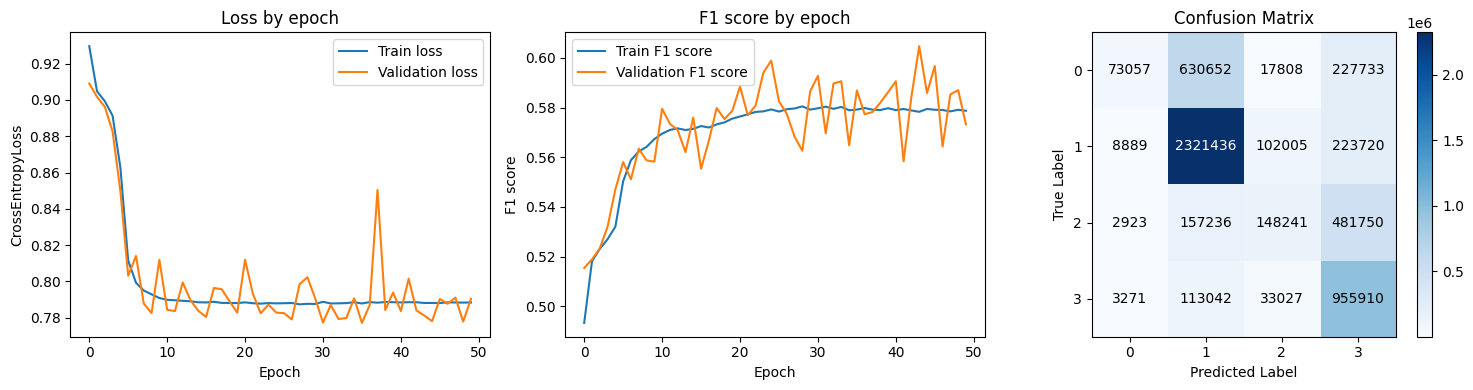

In [ ]:
cm = confusion_matrix(all_y_true,all_y_pred, labels=[0, 1, 2, 3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CrossEntropyLoss")

ax2.plot(train_metric_by_epoch, label="Train F1 score")
ax2.plot(valid_metric_by_epoch, label="Validation F1 score")
ax2.legend()
ax2.set_title("F1 score by epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1 score")

im = ax3.imshow(cm, interpolation='nearest', cmap='Blues')
ax3.set_title("Confusion Matrix")
ax3.set_xticks(range(len([0, 1, 2, 3])))
ax3.set_yticks(range(len([0, 1, 2, 3])))
ax3.set_xticklabels([0, 1, 2, 3])
ax3.set_yticklabels([0, 1, 2, 3])
ax3.set_xlabel("Predicted Label")
ax3.set_ylabel("True Label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax3.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax3)

plt.tight_layout()
plt.show()


### Observaciones
En este ejercicio se presenta un escenario donde hay un desbalance significativo entre las distintas clases (0, 1, 2, 3), en primer lugar se probó la técnica de _downsampling_ con la herramienta `resample` de sklearn lo cual no dió mejores resultados, dado esto, se optó por trabajar con el dataset original con el desbalance que presenta y utilizar:
- Parámetros disponibles respecto al desequilibrio de clases, tanto en las funciones de costo como en los modelos.
- Calcular los pesos de las clases y pasarlos como parámetros a la función de costo.
- Penalizar en función a cuantas muestras hay de cada clase, parámetro `weight_decay`.
- Evaluar con la métrica `F1-score`. Dado el desequilibrio, el modelo tiende a centrarse en predecir la clase mayoritaria, lo que puede causar que el recall de alto, y la precisión sea baja para las clases minoritarias. Esta métrica penaliza este comportamiento, asegurándose de que el modelo no descuide ninguna de las métricas.
  
### Interpretación de los gráficos

*Matriz de confusión*

Al observar los valores en la diagonal (de arriba a la izquierda a abajo a la derecha) que representan las predicciones correctas:
- **La clase 1 es mejor clasificada**, con pocos errores en comparación con el alto número de ejemplos correctos.
- Muchos ejemplos de la clase 0 se clasificaron erróneamente como clase 1.
- La clase 2 tiene errores significativos al ser clasificada como clase 3 (481.750 casos).

La clase mejor clasificada es la que más muestras tiene en el dataset, por lo que el modelo aprende mejor sus características en comparación del resto.

*Gráficos de loss y f1-score*

En los gráficos se observa que, la pérdida comienza disminuyendo signicativamente hasta la época 10 y desde ahi los valores se mantienen más o menos de manera similar. En la f1-score en principio se observa como aumenta de manera significativa hasta la época 10, luego sigue aumentando aunque más lentamente, la variación en esta métrica de validación podría deberse a datos de validación más ruidosos o a un conjunto de validación pequeño. Respecto al final de épocas los datos de entrenamiento y validación no se encuentran tan distantes.

### d) Modelo con 2 capas de embeddings.

- Productos

In [ ]:
ml_df.product_id.unique()

array([100069042, 100248942, 100087842, ..., 100370293, 100371644,
       100370853])

In [ ]:
product_id = ml_df['product_id']
user_id = ml_df['user_id']
x = ml_df.drop(['product_id','user_id','target'], axis=1)
y = ml_df['target']

In [ ]:
user_id.value_counts().to_frame('c').sample(20)

,c
user_id,
1004277,979
1004698,19
1001298,342
1005171,10
1000185,32
1002090,120
1002398,49
1003154,114
1004912,12


In [ ]:
x.head()

,occupation,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,age_encoded,gender_m,city_category_b,city_category_c
0,10,2,0,3,9,14,0,False,False,False
1,10,2,0,1,6,14,0,False,False,False
2,10,2,0,12,9,14,0,False,False,False
3,10,2,0,12,14,14,0,False,False,False
4,16,4,0,8,9,14,6,True,False,True


In [ ]:
y.head()

,target
0,1
1,3
2,0
3,0
4,1


In [ ]:
len(product_id.unique()) # type(product_id)

3631

In [ ]:
# Normalizacion
x = x.to_numpy()
y = y.to_numpy()
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

In [ ]:
# Divido el dataset
idx = np.random.permutation(x_norm.shape[0])
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]

train_x = x_norm[train_idx]
train_y = y[train_idx]
valid_x = x_norm[valid_idx]
valid_y = y[valid_idx]

n_train = train_x.shape[0]
n_valid = valid_x.shape[0]

In [ ]:
product_id.unique()

array([100069042, 100248942, 100087842, ..., 100370293, 100371644,
       100370853])

In [ ]:
product_id_to_idx = {value:i for i,value in enumerate(product_id.unique())}

In [ ]:
product_idx = np.array([product_id_to_idx[value] for value in product_id])

In [ ]:
product_idx_train = product_idx[train_idx]
product_idx_valid = product_idx[valid_idx]

In [ ]:
class MyDatasetWithEmbddings(Dataset):
  def __init__(self, x, product_idx, y):
    self.x = x.astype(np.float32) # Ensure x is of type float32
    self.product_idx = product_idx.astype(np.int64)
    self.y = y.astype(np.int64)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    # Convert NumPy arrays to PyTorch tensors
    return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.product_idx[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

In [ ]:
train_ds_embeddings = MyDatasetWithEmbddings(train_x, product_idx_train, train_y)
valid_ds_embeddings = MyDatasetWithEmbddings(valid_x, product_idx_valid, valid_y)

In [ ]:
train_x.shape

(467557, 10)

In [ ]:
product_idx_train.shape

(467557,)

In [ ]:
train_y.shape

(467557,)

In [ ]:
train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)

In [ ]:
embedding_dim = 64
in_features = 10

In [ ]:
# Arquitectura con embeddings
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embeddings = torch.nn.Embedding(num_embeddings=len(product_id.unique()), embedding_dim=embedding_dim)
    self.linear_1 = torch.nn.Linear(in_features=in_features+embedding_dim, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features=4, bias=True)

  def forward(self, x, product_idx):
    embeddings_outputs = self.embeddings(product_idx)
    x = torch.cat([x, embeddings_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [ ]:
nnnetWithEmbeddings = NNetWithEmbeddings()
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

In [ ]:
epochs = 30
learning_rate = 0.01


train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []
all_y_true = []
all_y_pred = []

loss_function =  torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=learning_rate, weight_decay=0.01)

# optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=learning_rate)
# loss_function = torch.nn.CrossEntropyLoss()

# Entrenamiento por épocas
for epoch in range(epochs):
    ############################################
    ## Entrenamiento
    ############################################
    nnnetWithEmbeddings.train()

    epoch_loss = 0
    epoch_y = []
    epoch_y_hat = []

    train_iterator = tqdm(train_dataloader_emb, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    for data in train_iterator:
        # Obtener datos del batch
        x_batch, embed_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        embed_batch = embed_batch.to(device)
        y_batch = y_batch.to(device).long()

        # Paso forward
        optimizer.zero_grad()
        nnet_output = nnnetWithEmbeddings(x_batch, embed_batch)

        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()

        y_batch_hat = torch.argmax(nnet_output, dim=1)
        epoch_y.extend(y_batch.cpu().numpy())
        epoch_y_hat.extend(y_batch_hat.cpu().numpy())
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader_emb)
    train_loss_by_epoch.append(epoch_loss)

    f1_score_train = metrics.f1_score(epoch_y, epoch_y_hat, average='weighted')
    train_metric_by_epoch.append(f1_score_train)

    ############################################
    ## Validación
    ############################################
    nnnetWithEmbeddings.eval()

    valid_epoch_loss = 0
    valid_epoch_y = []
    valid_epoch_y_hat = []

    valid_iterator = tqdm(valid_dataloader_emb, desc=f"Epoch {epoch + 1}/{epochs} [Valid]", leave=False)
    with torch.no_grad():  # Desactivar gradientes
        for data in valid_iterator:
            x_batch, embed_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch = embed_batch.to(device)
            y_batch = y_batch.to(device).long()

            nnet_output = nnnetWithEmbeddings(x_batch, embed_batch)

            loss = loss_function(nnet_output, y_batch)
            y_batch_hat = torch.argmax(nnet_output, dim=1)

            valid_epoch_y.extend(y_batch.cpu().numpy())
            valid_epoch_y_hat.extend(y_batch_hat.cpu().numpy())
            valid_epoch_loss += loss.item()

    valid_epoch_loss /= len(valid_dataloader_emb)
    valid_loss_by_epoch.append(valid_epoch_loss)

    f1_score_valid = metrics.f1_score(valid_epoch_y, valid_epoch_y_hat, average='weighted')
    valid_metric_by_epoch.append(f1_score_valid)

    # Guardar todas las etiquetas y predicciones de validación
    all_y_true += valid_epoch_y
    all_y_pred += valid_epoch_y_hat

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Valid Loss: {valid_epoch_loss:.4f} | "
          f"Train F1: {f1_score_train:.4f}, Valid F1: {f1_score_valid:.4f}")

Epoch 1/30 | Train Loss: 0.7874, Valid Loss: 0.7787 | Train F1: 0.5108, Valid F1: 0.5138


Epoch 2/30 | Train Loss: 0.7778, Valid Loss: 0.7723 | Train F1: 0.5114, Valid F1: 0.5071


Epoch 3/30 | Train Loss: 0.7783, Valid Loss: 0.7859 | Train F1: 0.5112, Valid F1: 0.5127


Epoch 4/30 | Train Loss: 0.7779, Valid Loss: 0.7742 | Train F1: 0.5111, Valid F1: 0.5111


Epoch 5/30 | Train Loss: 0.7778, Valid Loss: 0.7756 | Train F1: 0.5110, Valid F1: 0.5086


Epoch 6/30 | Train Loss: 0.7788, Valid Loss: 0.7735 | Train F1: 0.5116, Valid F1: 0.5117


Epoch 7/30 | Train Loss: 0.7783, Valid Loss: 0.7705 | Train F1: 0.5112, Valid F1: 0.5118


Epoch 8/30 | Train Loss: 0.7791, Valid Loss: 0.7786 | Train F1: 0.5107, Valid F1: 0.5112


Epoch 9/30 | Train Loss: 0.7789, Valid Loss: 0.7777 | Train F1: 0.5111, Valid F1: 0.5137


Epoch 10/30 | Train Loss: 0.7793, Valid Loss: 0.7822 | Train F1: 0.5108, Valid F1: 0.5124


Epoch 11/30 | Train Loss: 0.7789, Valid Loss: 0.7749 | Train F1: 0.5107, Valid F1: 0.5122


Epoch 12/30 | Train Loss: 0.7788, Valid Loss: 0.7772 | Train F1: 0.5109, Valid F1: 0.5097


Epoch 13/30 | Train Loss: 0.7790, Valid Loss: 0.7800 | Train F1: 0.5110, Valid F1: 0.5110


Epoch 14/30 | Train Loss: 0.7789, Valid Loss: 0.7777 | Train F1: 0.5107, Valid F1: 0.5129


Epoch 15/30 | Train Loss: 0.7792, Valid Loss: 0.7682 | Train F1: 0.5105, Valid F1: 0.5146


Epoch 16/30 | Train Loss: 0.7788, Valid Loss: 0.7692 | Train F1: 0.5107, Valid F1: 0.5150


Epoch 17/30 | Train Loss: 0.7788, Valid Loss: 0.7726 | Train F1: 0.5105, Valid F1: 0.5113


Epoch 18/30 | Train Loss: 0.7787, Valid Loss: 0.7693 | Train F1: 0.5107, Valid F1: 0.5258


Epoch 19/30 | Train Loss: 0.7787, Valid Loss: 0.7812 | Train F1: 0.5109, Valid F1: 0.5148


Epoch 20/30 | Train Loss: 0.7790, Valid Loss: 0.7902 | Train F1: 0.5111, Valid F1: 0.5129


Epoch 21/30 | Train Loss: 0.7786, Valid Loss: 0.7719 | Train F1: 0.5112, Valid F1: 0.5089


Epoch 22/30 | Train Loss: 0.7788, Valid Loss: 0.7800 | Train F1: 0.5107, Valid F1: 0.5142


Epoch 23/30 | Train Loss: 0.7785, Valid Loss: 0.7754 | Train F1: 0.5107, Valid F1: 0.5061


Epoch 24/30 | Train Loss: 0.7791, Valid Loss: 0.7753 | Train F1: 0.5112, Valid F1: 0.5104


Epoch 25/30 | Train Loss: 0.7788, Valid Loss: 0.7667 | Train F1: 0.5108, Valid F1: 0.5124


Epoch 26/30 | Train Loss: 0.7791, Valid Loss: 0.7898 | Train F1: 0.5107, Valid F1: 0.5054


Epoch 27/30 | Train Loss: 0.7785, Valid Loss: 0.7691 | Train F1: 0.5108, Valid F1: 0.5137


Epoch 28/30 | Train Loss: 0.7788, Valid Loss: 0.7968 | Train F1: 0.5110, Valid F1: 0.5136


Epoch 29/30 | Train Loss: 0.7788, Valid Loss: 0.7722 | Train F1: 0.5112, Valid F1: 0.5109


Epoch 30/30 | Train Loss: 0.7793, Valid Loss: 0.7724 | Train F1: 0.5109, Valid F1: 0.5322


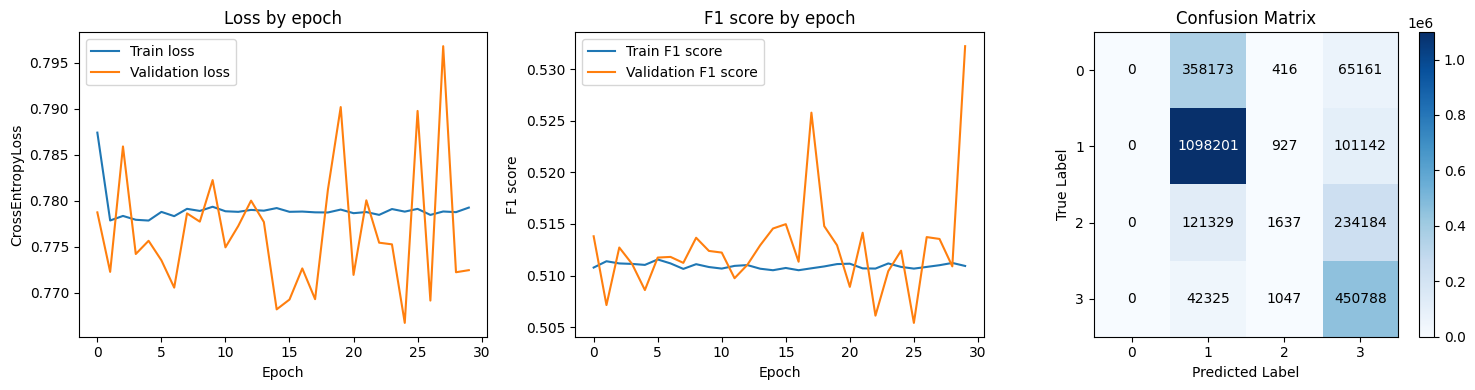

In [ ]:
cm = confusion_matrix(all_y_true,all_y_pred, labels=[0, 1, 2, 3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CrossEntropyLoss")

ax2.plot(train_metric_by_epoch, label="Train F1 score")
ax2.plot(valid_metric_by_epoch, label="Validation F1 score")
ax2.legend()
ax2.set_title("F1 score by epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1 score")

im = ax3.imshow(cm, interpolation='nearest', cmap='Blues')
ax3.set_title("Confusion Matrix")
ax3.set_xticks(range(len([0, 1, 2, 3])))
ax3.set_yticks(range(len([0, 1, 2, 3])))
ax3.set_xticklabels([0, 1, 2, 3])
ax3.set_yticklabels([0, 1, 2, 3])
ax3.set_xlabel("Predicted Label")
ax3.set_ylabel("True Label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax3.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax3)

plt.tight_layout()
plt.show()

- Usuarios

In [ ]:
len(user_id.unique())

5891

In [ ]:
user_id_to_idx = {value:i for i,value in enumerate(user_id.unique())}

In [ ]:
user_idx = np.array([user_id_to_idx[value] for value in user_id])

In [ ]:
user_idx_train = user_idx[train_idx]
user_idx_valid = user_idx[valid_idx]

In [ ]:
user_idx[128]

23

In [ ]:
class MyDatasetWithEmbddings(Dataset):
  def __init__(self, x, user_idx, y):
    self.x = x.astype(np.float32) # Ensure x is of type float32
    self.user_idx = user_idx.astype(np.int64)
    self.y = y.astype(np.int64)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    # Convert NumPy arrays to PyTorch tensors
    return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.user_idx[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

In [ ]:
train_ds_embeddings = MyDatasetWithEmbddings(train_x, user_idx_train, train_y)
valid_ds_embeddings = MyDatasetWithEmbddings(valid_x, user_idx_valid, valid_y)

In [ ]:
train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)

In [ ]:
# Arquitectura con embeddings
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embeddings = torch.nn.Embedding(num_embeddings=len(user_id.unique()), embedding_dim=embedding_dim)
    self.linear_1 = torch.nn.Linear(in_features=in_features+embedding_dim, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features=4, bias=True)

  def forward(self, x, user_idx):
    embeddings_outputs = self.embeddings(user_idx)
    x = torch.cat([x, embeddings_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x


In [ ]:
nnnetWithEmbeddings = NNetWithEmbeddings()
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

In [ ]:
epochs = 30
learning_rate = 0.001


train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []
all_y_true = []
all_y_pred = []

optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

# Entrenamiento por épocas
for epoch in range(epochs):
    ############################################
    ## Entrenamiento
    ############################################
    nnnetWithEmbeddings.train()

    epoch_loss = 0
    epoch_y = []
    epoch_y_hat = []

    train_iterator = tqdm(train_dataloader_emb, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    for data in train_iterator:
        # Obtener datos del batch
        x_batch, embed_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        embed_batch = embed_batch.to(device)
        y_batch = y_batch.to(device).long()

        # Paso forward
        optimizer.zero_grad()
        nnet_output = nnnetWithEmbeddings(x_batch, embed_batch)

        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()

        y_batch_hat = torch.argmax(nnet_output, dim=1)
        epoch_y.extend(y_batch.cpu().numpy())
        epoch_y_hat.extend(y_batch_hat.cpu().numpy())
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader_emb)
    train_loss_by_epoch.append(epoch_loss)

    f1_score_train = metrics.f1_score(epoch_y, epoch_y_hat, average='weighted')
    train_metric_by_epoch.append(f1_score_train)

    ############################################
    ## Validación
    ############################################
    nnnetWithEmbeddings.eval()

    valid_epoch_loss = 0
    valid_epoch_y = []
    valid_epoch_y_hat = []

    valid_iterator = tqdm(valid_dataloader_emb, desc=f"Epoch {epoch + 1}/{epochs} [Valid]", leave=False)
    with torch.no_grad():  # Desactivar gradientes
        for data in valid_iterator:
            x_batch, embed_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch = embed_batch.to(device)
            y_batch = y_batch.to(device).long()

            nnet_output = nnnetWithEmbeddings(x_batch, embed_batch)

            loss = loss_function(nnet_output, y_batch)
            y_batch_hat = torch.argmax(nnet_output, dim=1)

            valid_epoch_y.extend(y_batch.cpu().numpy())
            valid_epoch_y_hat.extend(y_batch_hat.cpu().numpy())
            valid_epoch_loss += loss.item()

    valid_epoch_loss /= len(valid_dataloader_emb)
    valid_loss_by_epoch.append(valid_epoch_loss)

    f1_score_valid = metrics.f1_score(valid_epoch_y, valid_epoch_y_hat, average='weighted')
    valid_metric_by_epoch.append(f1_score_valid)

    # Guardar todas las etiquetas y predicciones de validación
    all_y_true += valid_epoch_y
    all_y_pred += valid_epoch_y_hat

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train F1: {f1_score_train:.4f} | "
          f"Val Loss: {valid_epoch_loss:.4f}, Val F1: {f1_score_valid:.4f}")


Epoch 1/30 | Train Loss: 0.9847, Train F1: 0.5697 | Val Loss: 0.9244, Val F1: 0.5833


Epoch 2/30 | Train Loss: 0.8260, Train F1: 0.6526 | Val Loss: 0.7782, Val F1: 0.6697


Epoch 3/30 | Train Loss: 0.7583, Train F1: 0.6785 | Val Loss: 0.7523, Val F1: 0.6714


Epoch 4/30 | Train Loss: 0.7261, Train F1: 0.6909 | Val Loss: 0.7477, Val F1: 0.6966


Epoch 5/30 | Train Loss: 0.7079, Train F1: 0.6974 | Val Loss: 0.7303, Val F1: 0.6944


Epoch 6/30 | Train Loss: 0.6980, Train F1: 0.7000 | Val Loss: 0.7158, Val F1: 0.6751


Epoch 7/30 | Train Loss: 0.6910, Train F1: 0.7025 | Val Loss: 0.7090, Val F1: 0.6929


Epoch 8/30 | Train Loss: 0.6849, Train F1: 0.7048 | Val Loss: 0.7213, Val F1: 0.6791


Epoch 9/30 | Train Loss: 0.6801, Train F1: 0.7057 | Val Loss: 0.7098, Val F1: 0.6890


Epoch 10/30 | Train Loss: 0.6756, Train F1: 0.7068 | Val Loss: 0.7154, Val F1: 0.6817


Epoch 11/30 | Train Loss: 0.6718, Train F1: 0.7087 | Val Loss: 0.7109, Val F1: 0.7042


Epoch 12/30 | Train Loss: 0.6686, Train F1: 0.7094 | Val Loss: 0.7061, Val F1: 0.7007


Epoch 13/30 | Train Loss: 0.6650, Train F1: 0.7112 | Val Loss: 0.7178, Val F1: 0.6918


Epoch 14/30 | Train Loss: 0.6619, Train F1: 0.7125 | Val Loss: 0.7064, Val F1: 0.7019


Epoch 15/30 | Train Loss: 0.6597, Train F1: 0.7135 | Val Loss: 0.7270, Val F1: 0.6934


Epoch 16/30 | Train Loss: 0.6564, Train F1: 0.7147 | Val Loss: 0.7177, Val F1: 0.6977


Epoch 17/30 | Train Loss: 0.6540, Train F1: 0.7158 | Val Loss: 0.7227, Val F1: 0.6950


Epoch 18/30 | Train Loss: 0.6515, Train F1: 0.7167 | Val Loss: 0.7117, Val F1: 0.6950


Epoch 19/30 | Train Loss: 0.6496, Train F1: 0.7174 | Val Loss: 0.7207, Val F1: 0.7021


Epoch 20/30 | Train Loss: 0.6472, Train F1: 0.7183 | Val Loss: 0.7133, Val F1: 0.6994


Epoch 21/30 | Train Loss: 0.6451, Train F1: 0.7190 | Val Loss: 0.7164, Val F1: 0.6965


Epoch 22/30 | Train Loss: 0.6429, Train F1: 0.7200 | Val Loss: 0.7168, Val F1: 0.6976


Epoch 23/30 | Train Loss: 0.6410, Train F1: 0.7205 | Val Loss: 0.7332, Val F1: 0.6925


Epoch 24/30 | Train Loss: 0.6393, Train F1: 0.7212 | Val Loss: 0.7280, Val F1: 0.6918


Epoch 25/30 | Train Loss: 0.6374, Train F1: 0.7221 | Val Loss: 0.7184, Val F1: 0.6968


Epoch 26/30 | Train Loss: 0.6351, Train F1: 0.7229 | Val Loss: 0.7335, Val F1: 0.6776


Epoch 27/30 | Train Loss: 0.6337, Train F1: 0.7233 | Val Loss: 0.7247, Val F1: 0.6975


Epoch 28/30 | Train Loss: 0.6314, Train F1: 0.7242 | Val Loss: 0.7249, Val F1: 0.6974


Epoch 29/30 | Train Loss: 0.6297, Train F1: 0.7247 | Val Loss: 0.7398, Val F1: 0.6696


Epoch 30/30 | Train Loss: 0.6280, Train F1: 0.7255 | Val Loss: 0.7316, Val F1: 0.6858


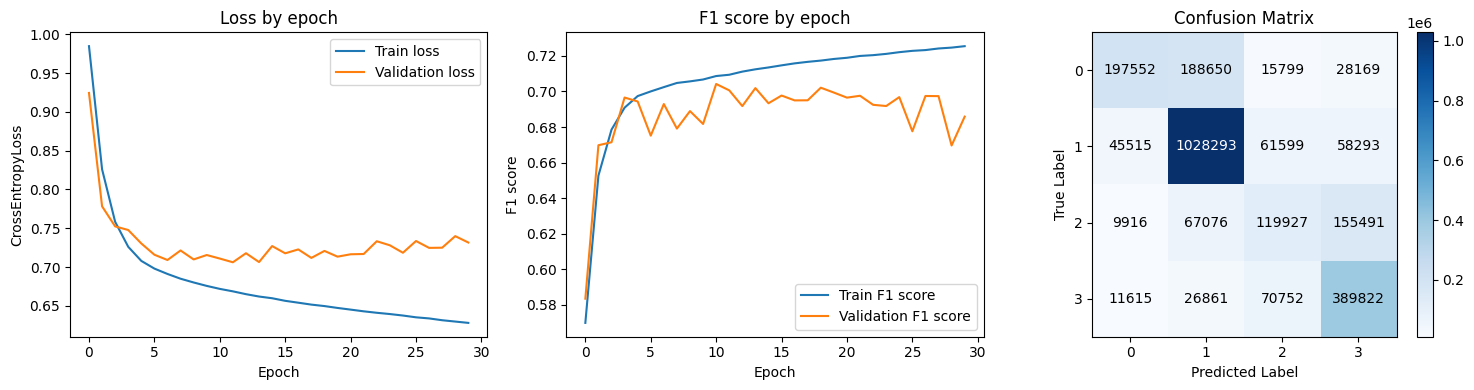

In [ ]:
cm = confusion_matrix(all_y_true,all_y_pred, labels=[0, 1, 2, 3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CrossEntropyLoss")

ax2.plot(train_metric_by_epoch, label="Train F1 score")
ax2.plot(valid_metric_by_epoch, label="Validation F1 score")
ax2.legend()
ax2.set_title("F1 score by epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1 score")

im = ax3.imshow(cm, interpolation='nearest', cmap='Blues')
ax3.set_title("Confusion Matrix")
ax3.set_xticks(range(len([0, 1, 2, 3])))
ax3.set_yticks(range(len([0, 1, 2, 3])))
ax3.set_xticklabels([0, 1, 2, 3])
ax3.set_yticklabels([0, 1, 2, 3])
ax3.set_xlabel("Predicted Label")
ax3.set_ylabel("True Label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax3.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax3)

plt.tight_layout()
plt.show()

### e) Funcion que recibe un id de usuario.

In [ ]:
def sugerir_usuarios_similares(user_id, n=5):
    """
    Sugiere usuarios similares en función del comportamiento de compra.

    Args:
        user_id: El ID del usuario para el que se buscan usuarios similares.
        n: El número de usuarios similares a sugerir.

    Returns:
        Una lista de IDs de usuarios similares.
    """
    user_idx = user_id_to_idx.get(user_id)
    if user_idx is None:
        raise ValueError(f"Usuario con ID {user_id} no encontrado en el conjunto de datos.")
    user_embedding = nnnetWithEmbeddings.embeddings(torch.tensor(user_idx, device=device)).detach().cpu().numpy()

    all_user_embeddings = nnnetWithEmbeddings.embeddings.weight.data.cpu().numpy()
    similarities = np.dot(all_user_embeddings, user_embedding)

    # obtener los índices de los usuarios más similares (excluyendo el usuario dado)
    most_similar_indices = np.argsort(similarities)[-n-1:-1]

    # convertir los índices a IDs de usuario
    most_similar_users = [idx_to_user_id[idx] for idx in most_similar_indices]

    return most_similar_users

In [ ]:
idx_to_user_id = {value: key for key, value in user_id_to_idx.items()}

In [ ]:
similar_users = sugerir_usuarios_similares(user_id=1000113, n=5)
print(similar_users)

[1001704, 1004554, 1005003, 1003287, 1003437]


## Parte 2

### 2.a

Se trabaja sobre el dataset FashionMNIST. Es un escenario de clasificación multiclase que van del 0 al 9.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

In [ ]:
import torchinfo as torchinfo
import time
import os

In [ ]:
# !pip install torchinfo

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

- Se obtiene dataset `FashionMNIST`

In [ ]:
# primero creamos el dataset
train_dataset = torchvision.datasets.FashionMNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#<---------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.FashionMNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(), #<------------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.97MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.5MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
# bloque de convolución
def conv_block(c_in, c_out, k=3, p='same', s=1, pk=2):
    return torch.nn.Sequential(                               # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk)                                # pooling
    )

- Se implentan las cinco variantes de la CNN con el fin de comparar su rendimiento, variando en: canales de entrada y de salida, número de capas, agregando dropout.

In [ ]:
class CNNVariant1(torch.nn.Module):
    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        self.conv1 = conv_block(c_in=n_channels, c_out=4, k=3, p='same', s=1, pk=2)
        self.conv2 = conv_block(c_in=4, c_out=8, k=3, p='same', s=1, pk=2)

        # Calcula dinámicamente la entrada de la capa fc
        dummy_input = torch.zeros(1, n_channels, 28, 28)  # Ejemplo con tamaño de entrada 28x28
        dummy_output = self.forward_convs(dummy_input)
        fc_input_dim = dummy_output.numel()

        self.fc = torch.nn.Linear(fc_input_dim, n_outputs)

    def forward_convs(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self.forward_convs(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

class CNNVariant5(torch.nn.Module):
    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        self.conv1 = conv_block(c_in=n_channels, c_out=8, k=3, p='same', s=1, pk=2)
        self.conv2 = conv_block(c_in=8, c_out=16, k=5, p='same', s=1, pk=2)  # Kernel más grande
        self.conv3 = conv_block(c_in=16, c_out=32, k=3, p='same', s=1, pk=2)
        self.conv4 = conv_block(c_in=32, c_out=64, k=3, p='same', s=1, pk=2)  # Capa extra

        # Calcular dinámicamente el tamaño de entrada de la capa fully connected
        dummy_input = torch.zeros(1, n_channels, 28, 28)  # Supongamos tamaño de entrada 28x28
        dummy_output = self.forward_convs(dummy_input)
        fc_input_dim = dummy_output.numel()

        self.fc = torch.nn.Linear(fc_input_dim, n_outputs)

    def forward_convs(self, x):
        """Aplica las capas convolucionales para calcular la salida."""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

    def forward(self, x):
        x = self.forward_convs(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

class CNNVariant2(torch.nn.Module):
    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        # Agregar una capa convolucional adicional
        self.conv1 = conv_block(c_in=n_channels, c_out=8, k=3, p='same', s=1, pk=2)
        self.conv2 = conv_block(c_in=8, c_out=16, k=3, p='same', s=1, pk=2)
        self.conv3 = conv_block(c_in=16, c_out=32, k=3, p='same', s=1, pk=2)
        self.fc = torch.nn.Linear(32 * 3 * 3, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

class CNNVariant3(torch.nn.Module):
    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        self.conv1 = conv_block(c_in=n_channels, c_out=8, k=5, p='same', s=1, pk=2)  # Kernel más grande
        self.conv2 = conv_block(c_in=8, c_out=16, k=3, p='same', s=1, pk=2)
        self.drop = torch.nn.Dropout2d(p=0.5)  # Dropout para regularización
        self.conv3 = conv_block(c_in=16, c_out=32, k=3, p='same', s=1, pk=2)
        self.fc = torch.nn.Linear(32 * 3 * 3, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.drop(x)  # Aplicar dropout
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

class CNNVariant4(torch.nn.Module):
    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        self.conv1 = conv_block(c_in=n_channels, c_out=16, k=3, p='same', s=1, pk=2)  # Más canales
        self.conv2 = conv_block(c_in=16, c_out=32, k=3, p='same', s=1, pk=2)
        self.conv3 = conv_block(c_in=32, c_out=64, k=3, p='same', s=1, pk=2)  # Más canales en la última capa
        self.fc = torch.nn.Linear(64 * 3 * 3, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [ ]:
models = [
    CNNVariant1(n_channels=1, n_outputs=10),
    CNNVariant5(n_channels=1, n_outputs=10),
    CNNVariant2(n_channels=1, n_outputs=10),
    CNNVariant3(n_channels=1, n_outputs=10),
    CNNVariant4(n_channels=1, n_outputs=10),
]

In [ ]:
def fit(models, dataloader, epochs=10, model_names=None):
    results = {}
    for idx, model in enumerate(models):
        model_name = model_names[idx] if model_names else f"Model_{idx+1}"
        print(f"Entrenando {model_name}...")

        # Enviamos el modelo al dispositivo
        model.to(device)

        # Definimos optimizador y función de pérdida
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        # Inicializamos métricas
        epoch_t_loss = []
        epoch_v_loss = []
        epoch_t_acc = []
        epoch_v_acc = []

        # Registramos el tiempo de inicio
        start_time = time.time()

        # Entrenamiento por épocas
        for epoch in range(1, epochs + 1):
            # Modo de entrenamiento
            model.train()
            train_loss, train_acc = [], []
            bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs}")
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                train_acc.append(acc)
                bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

            epoch_t_loss.append(np.mean(train_loss))
            epoch_t_acc.append(np.mean(train_acc))

            # Evaluación en validación
            model.eval()
            val_loss, val_acc = [], []
            bar = tqdm(dataloader['test'], desc="Validating")
            with torch.no_grad():
                for batch in bar:
                    X, y = batch
                    X, y = X.to(device), y.to(device)
                    y_hat = model(X)
                    loss = criterion(y_hat, y)
                    val_loss.append(loss.item())
                    acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                    val_acc.append(acc)
                    bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

            epoch_v_loss.append(np.mean(val_loss))
            epoch_v_acc.append(np.mean(val_acc))
            print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        # Tiempo de entrenamiento
        elapsed_time = time.time() - start_time

        # Tamaño del modelo
        model_path = f"{model_name}.pt"
        torch.save(model.state_dict(), model_path)
        model_size = os.path.getsize(model_path) / 1e6  # Convertir a MB
        os.remove(model_path)  # Eliminar archivo temporal

        # Guardar resultados
        results[model_name] = {
            "train_loss": epoch_t_loss,
            "val_loss": epoch_v_loss,
            "train_acc": epoch_t_acc,
            "val_acc": epoch_v_acc,
            "time": elapsed_time,
            "size_mb": model_size,
        }

    return results


In [ ]:
models = [CNNVariant1(), CNNVariant5(), CNNVariant2(), CNNVariant3(), CNNVariant4()]
model_names = ["CNNVariant1", "CNNVariant5", "CNNVariant2", "CNNVariant3", "CNNVariant4"]

In [ ]:
results = fit(models, dataloader, epochs=10, model_names=model_names)

Entrenando CNNVariant1...


val_loss 0.82309 val_acc 0.70492: 100%|██████████| 157/157 [00:05<00:00, 26.75it/s]


Epoch 1/10 loss 1.21173 val_loss 0.82309 acc 0.62525 val_acc 0.70492


val_loss 0.67916 val_acc 0.76602: 100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch 2/10 loss 0.73058 val_loss 0.67916 acc 0.74540 val_acc 0.76602


val_loss 0.60064 val_acc 0.78971: 100%|██████████| 157/157 [00:06<00:00, 24.72it/s]


Epoch 3/10 loss 0.62017 val_loss 0.60064 acc 0.78601 val_acc 0.78971


val_loss 0.55083 val_acc 0.80245: 100%|██████████| 157/157 [00:05<00:00, 31.13it/s]


Epoch 4/10 loss 0.55611 val_loss 0.55083 acc 0.80529 val_acc 0.80245


val_loss 0.52115 val_acc 0.81210: 100%|██████████| 157/157 [00:04<00:00, 32.35it/s]


Epoch 5/10 loss 0.51696 val_loss 0.52115 acc 0.81716 val_acc 0.81210


val_loss 0.49683 val_acc 0.82166: 100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


Epoch 6/10 loss 0.48996 val_loss 0.49683 acc 0.82673 val_acc 0.82166


val_loss 0.47993 val_acc 0.82524: 100%|██████████| 157/157 [00:04<00:00, 32.10it/s]


Epoch 7/10 loss 0.46975 val_loss 0.47993 acc 0.83362 val_acc 0.82524


val_loss 0.46388 val_acc 0.83330: 100%|██████████| 157/157 [00:04<00:00, 32.91it/s]


Epoch 8/10 loss 0.45291 val_loss 0.46388 acc 0.84035 val_acc 0.83330


val_loss 0.45124 val_acc 0.83838: 100%|██████████| 157/157 [00:06<00:00, 25.73it/s]


Epoch 9/10 loss 0.43931 val_loss 0.45124 acc 0.84452 val_acc 0.83838


val_loss 0.44002 val_acc 0.84325: 100%|██████████| 157/157 [00:06<00:00, 25.98it/s]


Epoch 10/10 loss 0.42767 val_loss 0.44002 acc 0.84878 val_acc 0.84325
Entrenando CNNVariant5...


val_loss 0.80099 val_acc 0.72960: 100%|██████████| 157/157 [00:06<00:00, 23.04it/s]


Epoch 1/10 loss 1.19415 val_loss 0.80099 acc 0.62693 val_acc 0.72960


val_loss 0.62085 val_acc 0.77498: 100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


Epoch 2/10 loss 0.67167 val_loss 0.62085 acc 0.76706 val_acc 0.77498


val_loss 0.53867 val_acc 0.80404: 100%|██████████| 157/157 [00:07<00:00, 21.24it/s]


Epoch 3/10 loss 0.55356 val_loss 0.53867 acc 0.80092 val_acc 0.80404


val_loss 0.48961 val_acc 0.81977: 100%|██████████| 157/157 [00:06<00:00, 23.01it/s]


Epoch 4/10 loss 0.49087 val_loss 0.48961 acc 0.82289 val_acc 0.81977


val_loss 0.45521 val_acc 0.83489: 100%|██████████| 157/157 [00:06<00:00, 25.59it/s]


Epoch 5/10 loss 0.44904 val_loss 0.45521 acc 0.83725 val_acc 0.83489


val_loss 0.42997 val_acc 0.84375: 100%|██████████| 157/157 [00:07<00:00, 22.17it/s]


Epoch 6/10 loss 0.41865 val_loss 0.42997 acc 0.84880 val_acc 0.84375


val_loss 0.41112 val_acc 0.84902: 100%|██████████| 157/157 [00:06<00:00, 25.31it/s]


Epoch 7/10 loss 0.39594 val_loss 0.41112 acc 0.85771 val_acc 0.84902


val_loss 0.39585 val_acc 0.85808: 100%|██████████| 157/157 [00:06<00:00, 22.59it/s]


Epoch 8/10 loss 0.37846 val_loss 0.39585 acc 0.86277 val_acc 0.85808


val_loss 0.38178 val_acc 0.86196: 100%|██████████| 157/157 [00:06<00:00, 25.22it/s]


Epoch 9/10 loss 0.36400 val_loss 0.38178 acc 0.86772 val_acc 0.86196


val_loss 0.37175 val_acc 0.86505: 100%|██████████| 157/157 [00:06<00:00, 22.54it/s]


Epoch 10/10 loss 0.35119 val_loss 0.37175 acc 0.87273 val_acc 0.86505
Entrenando CNNVariant2...


val_loss 0.77639 val_acc 0.73109: 100%|██████████| 157/157 [00:06<00:00, 23.63it/s]


Epoch 1/10 loss 1.16473 val_loss 0.77639 acc 0.64551 val_acc 0.73109


val_loss 0.63287 val_acc 0.77110: 100%|██████████| 157/157 [00:06<00:00, 23.39it/s]


Epoch 2/10 loss 0.67701 val_loss 0.63287 acc 0.75771 val_acc 0.77110


val_loss 0.56514 val_acc 0.79349: 100%|██████████| 157/157 [00:07<00:00, 22.18it/s]


Epoch 3/10 loss 0.57906 val_loss 0.56514 acc 0.79196 val_acc 0.79349


val_loss 0.52044 val_acc 0.80872: 100%|██████████| 157/157 [00:06<00:00, 23.26it/s]


Epoch 4/10 loss 0.52312 val_loss 0.52044 acc 0.81233 val_acc 0.80872


val_loss 0.48746 val_acc 0.82225: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s]


Epoch 5/10 loss 0.48327 val_loss 0.48746 acc 0.82628 val_acc 0.82225


val_loss 0.46272 val_acc 0.83270: 100%|██████████| 157/157 [00:06<00:00, 24.12it/s]


Epoch 6/10 loss 0.45371 val_loss 0.46272 acc 0.83685 val_acc 0.83270


val_loss 0.44385 val_acc 0.83668: 100%|██████████| 157/157 [00:06<00:00, 23.48it/s]


Epoch 7/10 loss 0.43124 val_loss 0.44385 acc 0.84497 val_acc 0.83668


val_loss 0.42797 val_acc 0.84435: 100%|██████████| 157/157 [00:06<00:00, 25.23it/s]


Epoch 8/10 loss 0.41317 val_loss 0.42797 acc 0.85133 val_acc 0.84435


val_loss 0.41555 val_acc 0.84952: 100%|██████████| 157/157 [00:06<00:00, 25.22it/s]


Epoch 9/10 loss 0.39813 val_loss 0.41555 acc 0.85621 val_acc 0.84952


val_loss 0.40392 val_acc 0.85201: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s]


Epoch 10/10 loss 0.38569 val_loss 0.40392 acc 0.86112 val_acc 0.85201
Entrenando CNNVariant3...


val_loss 0.84714 val_acc 0.69755: 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Epoch 1/10 loss 1.31995 val_loss 0.84714 acc 0.57238 val_acc 0.69755


val_loss 0.67194 val_acc 0.75557: 100%|██████████| 157/157 [00:06<00:00, 26.01it/s]


Epoch 2/10 loss 0.77616 val_loss 0.67194 acc 0.72956 val_acc 0.75557


val_loss 0.60169 val_acc 0.77617: 100%|██████████| 157/157 [00:05<00:00, 26.86it/s]


Epoch 3/10 loss 0.65508 val_loss 0.60169 acc 0.76672 val_acc 0.77617


val_loss 0.55994 val_acc 0.79459: 100%|██████████| 157/157 [00:05<00:00, 26.41it/s]


Epoch 4/10 loss 0.59404 val_loss 0.55994 acc 0.78576 val_acc 0.79459


val_loss 0.52820 val_acc 0.80643: 100%|██████████| 157/157 [00:06<00:00, 25.10it/s]


Epoch 5/10 loss 0.55741 val_loss 0.52820 acc 0.80056 val_acc 0.80643


val_loss 0.50398 val_acc 0.81379: 100%|██████████| 157/157 [00:06<00:00, 22.87it/s]


Epoch 6/10 loss 0.52736 val_loss 0.50398 acc 0.81125 val_acc 0.81379


val_loss 0.48283 val_acc 0.82444: 100%|██████████| 157/157 [00:06<00:00, 23.38it/s]


Epoch 7/10 loss 0.50438 val_loss 0.48283 acc 0.81931 val_acc 0.82444


val_loss 0.46920 val_acc 0.82693: 100%|██████████| 157/157 [00:06<00:00, 23.99it/s]


Epoch 8/10 loss 0.48509 val_loss 0.46920 acc 0.82729 val_acc 0.82693


val_loss 0.45446 val_acc 0.83529: 100%|██████████| 157/157 [00:06<00:00, 25.31it/s]


Epoch 9/10 loss 0.47023 val_loss 0.45446 acc 0.83197 val_acc 0.83529


val_loss 0.44120 val_acc 0.84066: 100%|██████████| 157/157 [00:07<00:00, 21.34it/s]


Epoch 10/10 loss 0.45608 val_loss 0.44120 acc 0.83632 val_acc 0.84066
Entrenando CNNVariant4...


val_loss 0.64591 val_acc 0.75945: 100%|██████████| 157/157 [00:09<00:00, 17.31it/s]


Epoch 1/10 loss 0.94961 val_loss 0.64591 acc 0.68632 val_acc 0.75945


val_loss 0.51815 val_acc 0.81101: 100%|██████████| 157/157 [00:08<00:00, 17.73it/s]


Epoch 2/10 loss 0.55728 val_loss 0.51815 acc 0.79974 val_acc 0.81101


val_loss 0.45821 val_acc 0.83300: 100%|██████████| 157/157 [00:08<00:00, 19.32it/s]


Epoch 3/10 loss 0.46841 val_loss 0.45821 acc 0.83367 val_acc 0.83300


val_loss 0.41865 val_acc 0.84723: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Epoch 4/10 loss 0.41919 val_loss 0.41865 acc 0.85100 val_acc 0.84723


val_loss 0.39070 val_acc 0.85918: 100%|██████████| 157/157 [00:08<00:00, 18.81it/s]


Epoch 5/10 loss 0.38586 val_loss 0.39070 acc 0.86281 val_acc 0.85918


val_loss 0.37153 val_acc 0.86574: 100%|██████████| 157/157 [00:08<00:00, 18.57it/s]


Epoch 6/10 loss 0.36186 val_loss 0.37153 acc 0.86974 val_acc 0.86574


val_loss 0.35584 val_acc 0.87062: 100%|██████████| 157/157 [00:08<00:00, 18.44it/s]


Epoch 7/10 loss 0.34380 val_loss 0.35584 acc 0.87573 val_acc 0.87062


val_loss 0.34455 val_acc 0.87301: 100%|██████████| 157/157 [00:08<00:00, 18.25it/s]


Epoch 8/10 loss 0.32893 val_loss 0.34455 acc 0.88108 val_acc 0.87301


val_loss 0.33389 val_acc 0.87898: 100%|██████████| 157/157 [00:08<00:00, 19.07it/s]


Epoch 9/10 loss 0.31694 val_loss 0.33389 acc 0.88581 val_acc 0.87898


val_loss 0.32977 val_acc 0.88008: 100%|██████████| 157/157 [00:07<00:00, 20.20it/s]

Epoch 10/10 loss 0.30636 val_loss 0.32977 acc 0.89008 val_acc 0.88008


In [ ]:
def plot_results(results):
    # Configuración de subplots
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    for i, (model_name, data) in enumerate(results.items()):
        # Graficar Loss (Train vs Val)
        axes[i].plot(data['train_loss'], label="Train Loss", color='blue')
        axes[i].plot(data['val_loss'], label="Val Loss", color='orange')
        axes[i].set_title(f"{model_name} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()

        # Graficar Accuracy (Train vs Val)
        axes[i + 5].plot(data['train_acc'], label="Train Accuracy", color='blue')
        axes[i + 5].plot(data['val_acc'], label="Val Accuracy", color='orange')
        axes[i + 5].set_title(f"{model_name} Accuracy")
        axes[i + 5].set_xlabel("Epochs")
        axes[i + 5].set_ylabel("Accuracy")
        axes[i + 5].legend()

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()


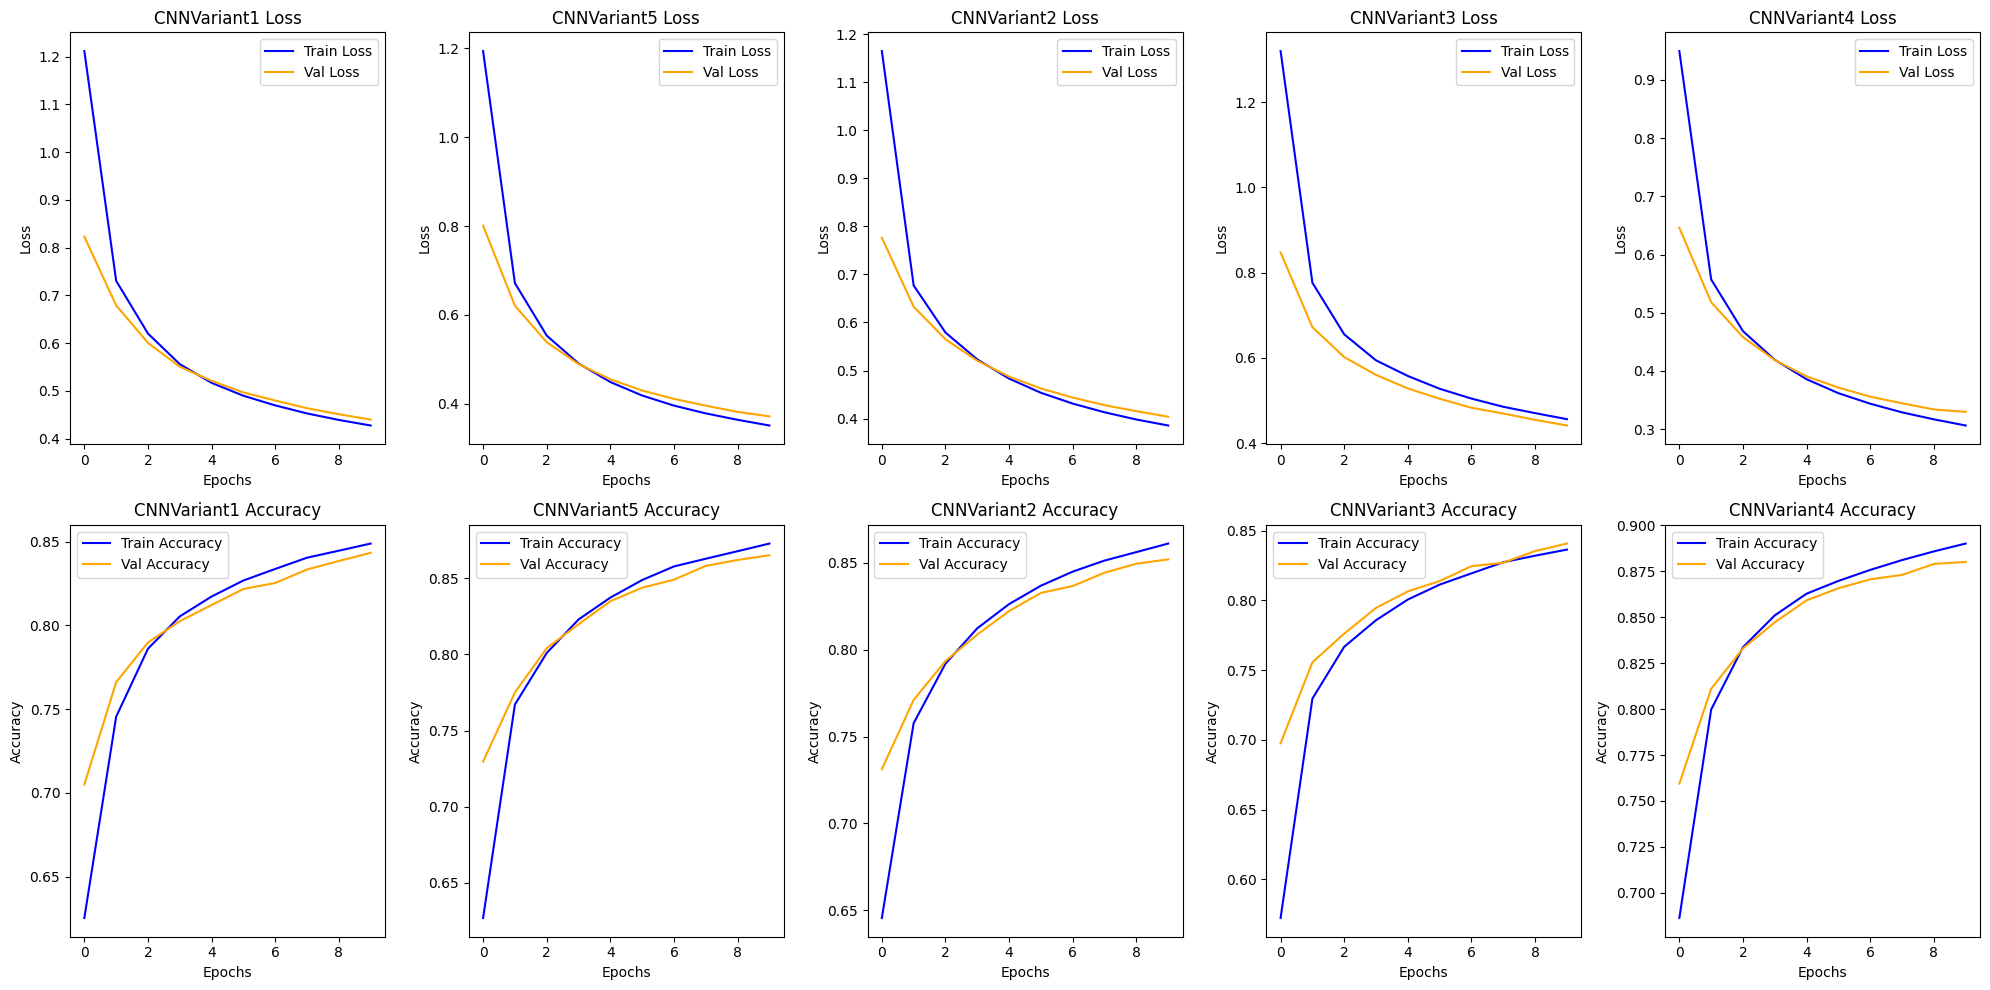

In [ ]:
plot_results(results)

### Observaciones

_Tabla Comparativa de Arquitecturas_

| CNNVariant | Epoch | Loss | Accuracy | Time | Size (mb) |
| --- | --- | --- | --- | --- | --- |
| CNNVariant1 | 10 | 0.44 | 0.84|  438.48|  0.019|
| CNNVariant5 | 10 | 0.37 | 0.86 | 653.70 | 0.11 |
| CNNVariant2 | 10 | 0.44 | 0.85 | 519.89 | 0.03 |
| CNNVariant3 | 10 | 0.44 | 0.84 | 536.55 | 0.03 |
| CNNVariant4 | 10 |**0.30**| **0.88** |756.28 | 0.11 |


_Interpretación de gráficos_

En este ejercicio al momento de definir las variantes para
probar en cada modelo, se tuvo en cuenta que para mejorar un modelo se
puede variar entre: aumentar la cantidad de capas, aumentar el tamaño
del kernel, y cantidad de canales.

Interpretación de resultados

Observando las gráficas se puede ver que la **mejor performance** se logró en la **variante número cuatro** la cual obtuvo tanto la menor _loss_ como el mejor _accuracy_ comparando con los resultados del resto.
Esto se logró con los parámetros:
 - cuatro capas donde se detalla:
      - self.conv1 = conv_block(c_in=n_channels, c_out=**16**, k=3, p='same', s=1, pk=2)
      - self.conv2 = conv_block(c_in=**16**, c_out=**32**, k=3, p='same', s=1, pk=2)
      - self.conv3 = conv_block(c_in=**32**, c_out=**64**, k=3, p='same', s=1, pk=2)  
      - self.fc = torch.nn.Linear(**64** * 3 * 3, n_outputs)

En este caso el pooling, kernel y stride se mantuvieron constantes y se varió en la cantidad de capas y tamaños en entrada y salida, al aumentar estas dos últimas fue suficiente para lograr una mejor métrica y pérdida comparando con las otras variantes.  Al aumentar `c_in` y `c_out` (por ejemplo, de 32 a 64), se incrementa la cantidad de información que llega a la capa densa, esto ayuda a mejorar la capacidad de clasificación, ya que la capa totalmente conectada tiene más datos para generar una predicción.  

### 2.b

In [ ]:
class CNNVariant4TransferLearning(CNNVariant4):
    def __init__(self, n_channels=1, n_outputs=10, pretrained=False):
        super().__init__(n_channels, n_outputs)

        if pretrained:
            self.freeze_conv_layers()

    def freeze_conv_layers(self):
        """Congelar las capas convolucionales para Transfer Learning"""
        for param in self.conv1.parameters():
            param.requires_grad = False
        for param in self.conv2.parameters():
            param.requires_grad = False
        for param in self.conv3.parameters():
            param.requires_grad = False

    def unfreeze_fc_layers(self):
        """Descongelar la capa totalmente conectada para entrenamiento"""
        for param in self.fc.parameters():
            param.requires_grad = True

model = CNNVariant4TransferLearning(pretrained=True)  # Congelar capas convolucionales

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

criterion = nn.CrossEntropyLoss()

print("Parámetros entrenables:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")

Parámetros entrenables:
  fc.weight
  fc.bias


In [ ]:
class BinaryCNNVariant4(nn.Module):
    def __init__(self, n_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 3 * 3, 1)  # Salida binaria (logit único)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Etiquetas binarias: >= 5 -> 1, < 5 -> 0
train_dataset.targets = (train_dataset.targets >= 5).float()
test_dataset.targets = (test_dataset.targets >= 5).float()

n_samples = 20000
targets = np.array(train_dataset.targets)

balanced_indices = []
for class_label in range(2):
    class_indices = np.where(targets == class_label)[0]
    selected_indices = np.random.choice(class_indices, size=n_samples // 2, replace=False)
    balanced_indices.extend(selected_indices)

balanced_indices = np.array(balanced_indices)
balanced_train_dataset = Subset(train_dataset, balanced_indices)

In [ ]:
# Crear dataloaders
dataloader = {
    'train': DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

print(f"Tamaño del conjunto de entrenamiento balanceado: {len(balanced_train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento balanceado: 20000
Tamaño del conjunto de prueba: 10000


In [ ]:
model = BinaryCNNVariant4().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/10, Train Loss: 0.0075, Train Accuracy: 0.9975, Test Loss: 0.0717, Test Accuracy: 0.9818


Epoch 2/10, Train Loss: 0.0096, Train Accuracy: 0.9966, Test Loss: 0.0623, Test Accuracy: 0.9842


Epoch 3/10, Train Loss: 0.0057, Train Accuracy: 0.9979, Test Loss: 0.0695, Test Accuracy: 0.9836


Epoch 4/10, Train Loss: 0.0050, Train Accuracy: 0.9986, Test Loss: 0.0858, Test Accuracy: 0.9801


Epoch 5/10, Train Loss: 0.0172, Train Accuracy: 0.9942, Test Loss: 0.0525, Test Accuracy: 0.9862


Epoch 6/10, Train Loss: 0.0028, Train Accuracy: 0.9994, Test Loss: 0.0574, Test Accuracy: 0.9859


Epoch 7/10, Train Loss: 0.0012, Train Accuracy: 0.9997, Test Loss: 0.0604, Test Accuracy: 0.9869


Epoch 8/10, Train Loss: 0.0004, Train Accuracy: 1.0000, Test Loss: 0.0600, Test Accuracy: 0.9878


Epoch 9/10, Train Loss: 0.0002, Train Accuracy: 1.0000, Test Loss: 0.0629, Test Accuracy: 0.9874


Epoch 10/10, Train Loss: 0.0001, Train Accuracy: 1.0000, Test Loss: 0.0630, Test Accuracy: 0.9877


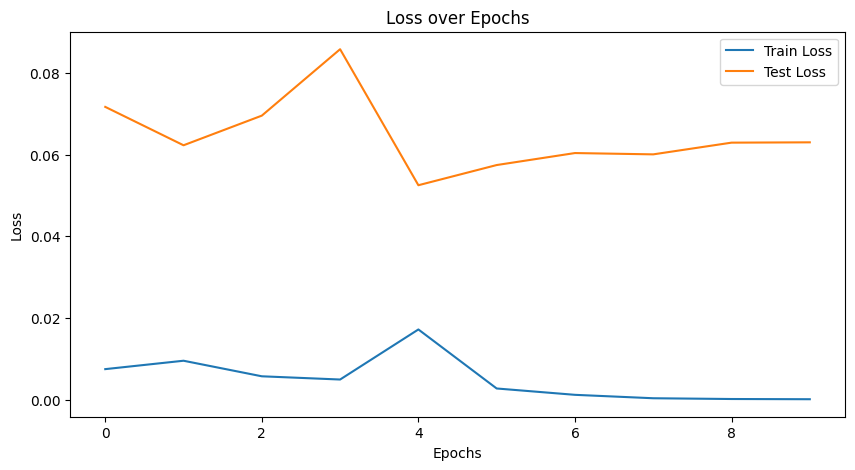

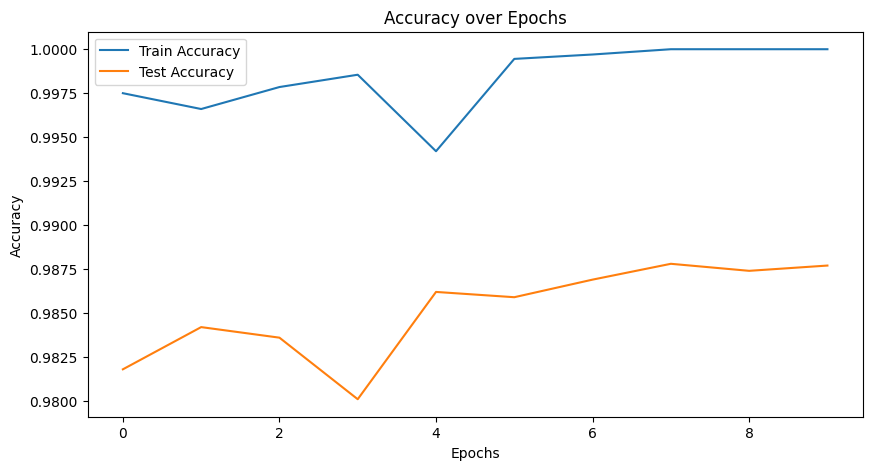

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader = tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{epochs} - Train", leave=False)
    for images, labels in train_loader:
        # Asegurarse de que las etiquetas estén en float
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)  # Logit único por muestra
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(dataloader['train'])
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0

    test_loader = tqdm(dataloader['test'], desc=f"Epoch {epoch+1}/{epochs} - Test", leave=False)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze(1)
            test_loss += criterion(outputs, labels).item()
            # Convertir logits a predicciones binarias
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            correct_test += (predictions == labels).sum().item()
            total_test += labels.size(0)

    test_loss = test_loss / len(dataloader['test'])
    test_accuracy = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

En este ejercicio se plantea un problema de clasificación binaria dado que la consigna solicita identificar los números mayores o menores a 4,5. Para esto, luego de la lectura de los datos, se realizó:
-  Proceso de asignar etiquetas binarias evaluando sobre la variable objetivo.
-  Proceso de extraer la cantidad de muestras solicitadas
-  Balancear las clases.

En cuanto a la función de pérdida se utilizó una correspondiente a
problemas de clasificación binaria.

_Interpretación de resultados_

El modelo arranca con un valor cercano a 1 en la accuracy, esto se debe a que modelo está aprendiendo la representación de los datos, es decir se produce **overffiting**. En posteriores análisis se puede agregar una capa de **Dropout** como se hizo en el apartado 2.a para manejar este comportamiento.

